In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\asgar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data from CSV
data = pd.read_csv('data.csv')

# Drop the timestamp
data = data.drop(['timestamp'], axis=1)

# Split data into 80% training and 20% testing
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Separate the testing data into normal (5%) and anomalies (15%)
normal_data = test_data.sample(frac=0.25, random_state=42)  # 5% normal (25% of 20%)
anomaly_data = test_data.drop(normal_data.index)  # Remaining 15% will be anomalies
y_true = np.concatenate([np.ones(len(normal_data)), np.zeros(len(anomaly_data))])

In [3]:
# Systematically introduce anomalies into the normal data
anomaly_data['ram_usage'] = anomaly_data['ram_usage'] * 1.25
anomaly_data['ram_usage'] = anomaly_data['ram_usage'].clip(upper=1.0)

anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'] * 1.50
anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'] * 1.60
anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'] * 1.30
anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'].clip(upper=1.0)

anomaly_data['network_bytes_sent'] = anomaly_data['network_bytes_sent'] * 1.10

In [4]:
# Combine back the normal and anomalous data for testing
test_data = pd.concat([normal_data, anomaly_data])

# List of columns that are already scaled and should not be scaled again
already_scaled_columns = ['cpu_usage', 'ram_usage', 'vram_usage', 'average_process_cpu_usage', 'average_process_ram_usage']

# Select columns that need scaling by excluding already scaled columns
columns_to_scale = [col for col in train_data.columns if col not in already_scaled_columns]

# Apply scaling only to the columns that need it
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

# Prepare the data
X_train = pd.concat([train_data[already_scaled_columns], train_data[columns_to_scale]], axis=1)
X_test = pd.concat([test_data[already_scaled_columns], test_data[columns_to_scale]], axis=1)

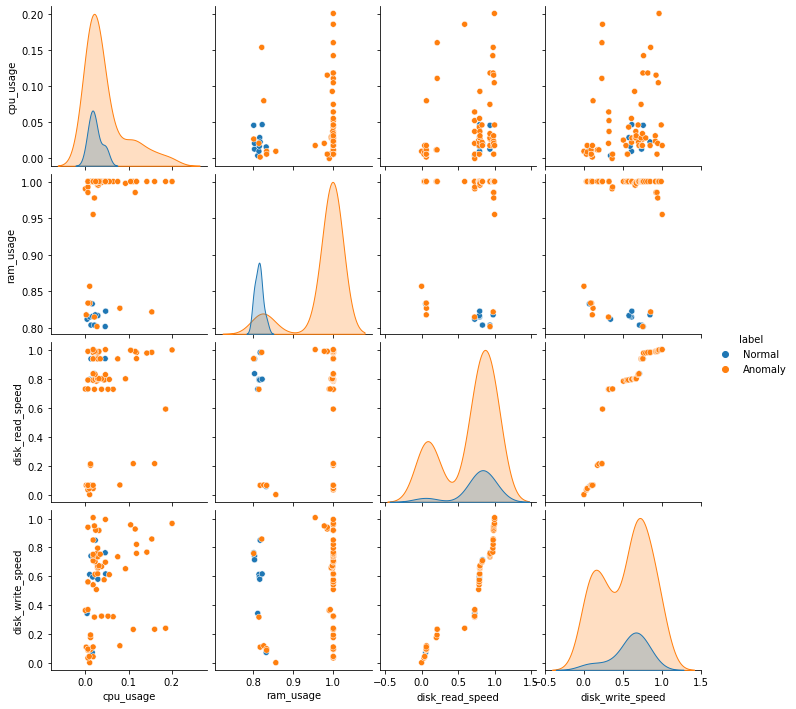

Confusion Matrix:
[[53  0]
 [ 8 10]]

---

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        53
         1.0       1.00      0.56      0.71        18

    accuracy                           0.89        71
   macro avg       0.93      0.78      0.82        71
weighted avg       0.90      0.89      0.88        71



In [5]:
# Initialize Local Outlier Factor (LOF)
lof = LocalOutlierFactor(
    n_neighbors=16,
    contamination=0.50,
    novelty=True
)

train_predictions = lof.fit(X_train)
predictions = lof.predict(X_test)

# Separate anomalies and normal data for visualization
anomalies = test_data[predictions == -1] # -1 for anomalies
normal = test_data[predictions == 1] # 1 for normal

# Combine normal and anomalies data with a label for easier plotting
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed'])
plt.show()

# Confusion Matrix
y_pred = np.where(predictions == 1, 1, 0)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\n---\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))


All Results:
    n_neighbors  contamination  accuracy  precision    recall  f1_score
0            10           0.15  0.985915        1.0  0.944444  0.971429
1            10           0.25  0.971831        1.0  0.888889  0.941176
2            10           0.30  0.929577        1.0  0.722222  0.838710
3            10           0.40  0.887324        1.0  0.555556  0.714286
4            10           0.50  0.887324        1.0  0.555556  0.714286
5            15           0.15  0.971831        1.0  0.888889  0.941176
6            15           0.25  0.971831        1.0  0.888889  0.941176
7            15           0.30  0.957746        1.0  0.833333  0.909091
8            15           0.40  0.901408        1.0  0.611111  0.758621
9            15           0.50  0.859155        1.0  0.444444  0.615385
10           20           0.15  0.985915        1.0  0.944444  0.971429
11           20           0.25  0.971831        1.0  0.888889  0.941176
12           20           0.30  0.971831        1.

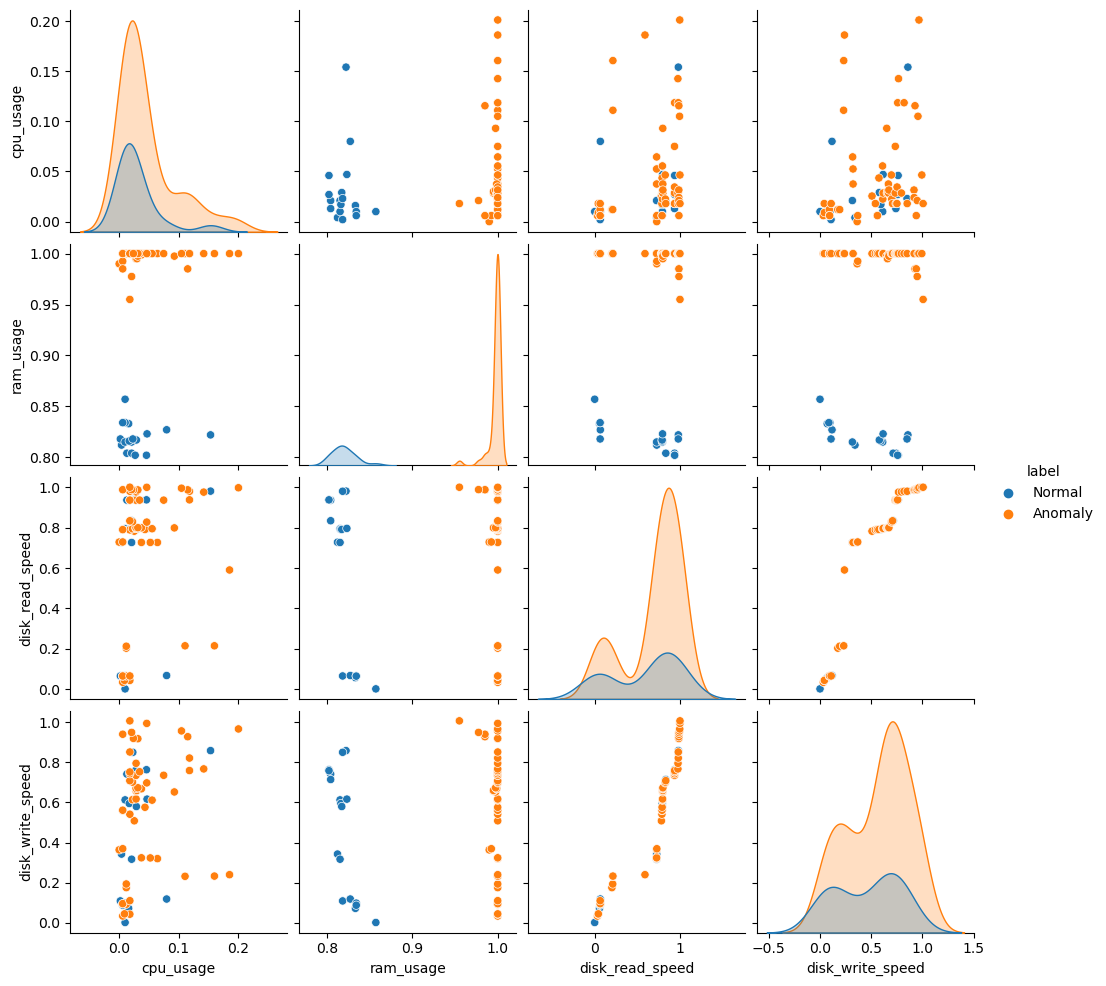

In [6]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define ranges for LOF hyperparameters
n_neighbors_list = [10, 15, 20, 25, 30]  # Commonly used values for k (n_neighbors)
contamination_levels = [0.15, 0.25, 0.3, 0.4, 0.5]  # Proportion of data expected to be anomalies

# Initialize results list
results = []
best_f1 = 0

for n_neighbors in n_neighbors_list:
    for contamination in contamination_levels:
        # Initialize the Local Outlier Factor (LOF) model with current hyperparameters
        lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True
        )
        
        # Fit the model on the non-anomalous training data
        lof.fit(X_train)
        
        # Predict anomalies on the test data
        predictions = lof.predict(X_test)
        y_pred = np.where(predictions == 1, 1, 0)

        # Calculate classification metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # Append results for this configuration
        results.append({
            'n_neighbors': n_neighbors,
            'contamination': contamination,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        # Check if current F1-score is the best
        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                'n_neighbors': n_neighbors,
                'contamination': contamination,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'y_pred': y_pred
            }

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nAll Results:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_df)

# Sort the DataFrame by 'f1_score' in descending order
results_df_sorted = results_df.sort_values(by='f1_score', ascending=False)

# Print the top results
print("\nTop Results:")
print(results_df_sorted.head(20))

# Display the confusion matrix for the best configuration
conf_matrix = confusion_matrix(y_true, best_params['y_pred'])
print("\nConfusion Matrix of the best model:")
print(conf_matrix)

# Display the classification report for the best configuration
print("\nClassification Report of the best model:")
print(classification_report(y_true, best_params['y_pred']))

# Plot pairplot for visualization
anomalies = test_data[best_params['y_pred'] == 0]  # 0 for anomalies
normal = test_data[best_params['y_pred'] == 1]  # 1 for normal
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed']
)
plt.show()
